In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings
from scipy.interpolate import CubicSpline

In [2]:
warnings.filterwarnings("ignore")

In [3]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Ano')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [4]:
def centered_moving_average(column, window_action, window_size):
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)

    for i in range(start_index, end_index + 1):
        if not np.isnan(data[i]):
            init = data[i]
            start = max(0, i - window_size)
            end = min(data_length, i + window_size + 1)
            window = data[start:end]
            valid_values = [value for value in window if not pd.isna(value)]
            if len(valid_values) > 0:
                data[i] = np.mean(valid_values)

    modified_column = pd.Series(data, name=column.name)

    return modified_column

In [13]:
# Cubic spline Interpolation data inputation method
def four_ends_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        for i in range(4):
            column = first_filler(column, i, len(column) - 1 - i)
            column = last_filler(column, i, len(column) - 1 - i)
    return column

def four_ends_linear_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        size = len(column) - 1
        column = first_filler(column, 0, size)
        column = last_filler(column, 0, size)
        for i in range(1, 4):
            value = column.at[i]
            if (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_first = i - 1
                end_first = next_valid_index(column, i)
                linear_a = (column.at[end_first] - column.at[i - 1])/(end_first - start_first)
                linear_b = column.at[start_first] - linear_a*start_first
                column.at[i] = linear_a*i + linear_b
            x = size - 4 + i
            value = column.at[x]
            if (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_last = prev_valid_index(column, x)
                end_last = next_valid_index(column, x)
                gap = list(range(start_last + 1, end_last))
                linear_a = (column.at[end_last] - column.at[start_last])/(end_last - start_last)
                linear_b = column.at[start_last] - linear_a*start_last
                column.at[x] = linear_a*x + linear_b
    return column

def first_filler(column, init, end):
    if pd.isnull(column.at[init]) or np.isnan(column.at[init]):
        first_valid_index = 0
        while first_valid_index <= end and (pd.isnull(column.at[first_valid_index]) or 
                                             np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > end:
            column.at[init] = 0.0
        else:
            column.at[init] = column.at[first_valid_index]
    return column
    
def last_filler(column, init, end):
    if pd.isnull(column.at[end]) or np.isnan(column.at[end]):
        last_valid_index = len(column) -1
        while last_valid_index >= init and (pd.isnull(column.at[last_valid_index]) or 
                                         np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < init:
            column.at[end] = 0.0
        else:
            column.at[end] = column.at[last_valid_index]
    return column
  
def neareast_four_indexes(column, start, end):
    return prev_four_valid_indexes(column, start) + next_four_valid_indexes(column, end)

def prev_four_valid_indexes(column, pos):
    prev_index = pos
    index_prev_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_prev_list[3 - i] = prev_index
            prev_index -= 1
            while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
                prev_index -= 1
    return index_prev_list  

def next_four_valid_indexes(column, pos):
    next_index = pos
    index_next_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_next_list[i] = next_index
            next_index += 1
            while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
                next_index += 1
    return index_next_list  

def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        prev_index -= 1
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        next_index += 1
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def interpolating_polynomial(nearest_indexes, nearest_values):
    coeffs = np.polyfit(nearest_indexes, nearest_values, 3)
    return np.poly1d(coeffs)

def polynomial_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                polynomial = interpolating_polynomial(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = polynomial(x)
                plot_polynomial(polynomial, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes, column.name)
    return column

def plot_polynomial(polynomial, start, end, precision, interpolated_list, nearest_indexes, column_name):
    x = np.linspace(start, end, precision)
    y = polynomial(x)

    plt.figure()

    plt.plot(x, y)

    interpolated_x = interpolated_list  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='red')
    interpolated_x = nearest_indexes  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='green')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(column_name)

    plt.show()
    
def replace_negative_with_float_zeros(x):
    return 0.0 if x < 0 else x

In [14]:
def read_csv_replace_missing_by_polynomial(file_path, skiped_rows, skiped_columns):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=skiped_rows)
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > skiped_columns:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = four_ends_linear_filler(df[col])
                df[col] = centered_moving_average(df[col], (0, len(df[col]) - 1), 24) #2 anos
                df[col] = polynomial_filler(df[col])
            i += 1
        return df

In [15]:
df = read_csv_replace_missing_by_polynomial('roraima_variacao_climatica.csv', 0, 1)
df.rename(columns={'Date': 'Ano'}, inplace=True)
df['Ano'] = df['Ano'].str[:4].astype(int)
df.drop(columns='State', inplace=True)
df.drop(columns='Year', inplace=True)
df.head(len(df))

,Ano,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
0,2011,1.892645,1001.395748,1509.793752,27.375661,21.344018,71.850223,1.819906
1,2011,1.909101,1001.431630,1503.603014,27.390774,21.366857,71.878108,1.824683
2,2011,1.820508,1001.453856,1505.178963,27.415353,21.345247,71.705867,1.832591
3,2011,1.790151,1001.490766,1505.878863,27.450711,21.337799,71.554526,1.834650
4,2011,1.853389,1001.539983,1494.652524,27.398832,21.383777,71.950661,1.816445
...,...,...,...,...,...,...,...,...
139,2022,0.745172,1001.374230,1008.306854,28.513955,20.075319,60.196356,2.240557
140,2022,0.757114,1001.331267,998.241421,28.548207,20.063853,60.165825,2.190392
141,2022,0.773218,1001.323338,981.419806,28.561202,20.052777,60.150702,2.163537
142,2022,0.796006,1001.348345,963.303094,28.566042,20.040037,60.136093,2.164434


In [16]:
df_year = df.copy()
df_year.set_index('Ano', inplace=True)
df_year = df_year.groupby('Ano').mean()
df_year['Precipitation (mm/day)'] = df_year['Precipitation (mm/day)'] * 12
df_year

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
Ano,,,,,,,
2011,22.217634,1001.541199,1506.456126,27.425647,21.330889,71.595088,1.830447
2012,21.157249,1001.690342,1515.527356,27.608612,21.117524,70.061650,1.898255
2013,18.013769,1001.817868,1528.998642,27.762053,20.876766,68.552790,1.943125
2014,14.644773,1001.940536,1542.131372,27.986329,20.647922,66.896135,1.956684
2015,19.007683,1001.988306,1541.272845,28.048825,20.665808,66.738045,1.910770
2016,24.437747,1002.055065,1514.905960,27.959130,20.665948,67.018448,1.902067
2017,26.318142,1002.155784,1495.611624,27.867978,20.547545,66.903661,1.943183
2018,28.548818,1002.183834,1468.719756,27.821635,20.578691,67.224766,1.912675
2019,24.615921,1001.746371,1214.342104,28.427536,20.385092,64.243880,1.959458


In [17]:
df_2014 = df_year[df_year.index >= 2014]
df_2014

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
Ano,,,,,,,
2014,14.644773,1001.940536,1542.131372,27.986329,20.647922,66.896135,1.956684
2015,19.007683,1001.988306,1541.272845,28.048825,20.665808,66.738045,1.910770
2016,24.437747,1002.055065,1514.905960,27.959130,20.665948,67.018448,1.902067
2017,26.318142,1002.155784,1495.611624,27.867978,20.547545,66.903661,1.943183
2018,28.548818,1002.183834,1468.719756,27.821635,20.578691,67.224766,1.912675
2019,24.615921,1001.746371,1214.342104,28.427536,20.385092,64.243880,1.959458
2020,15.236170,1001.355351,881.861438,29.108198,20.010993,59.875634,2.142193
2021,9.673941,1001.344782,867.033434,28.876218,19.963349,59.298235,2.217953
2022,9.037557,1001.455310,994.638947,28.471336,20.091016,60.304102,2.178437


In [18]:
df_2014.to_csv('2014_01_meteo.csv', index=True)

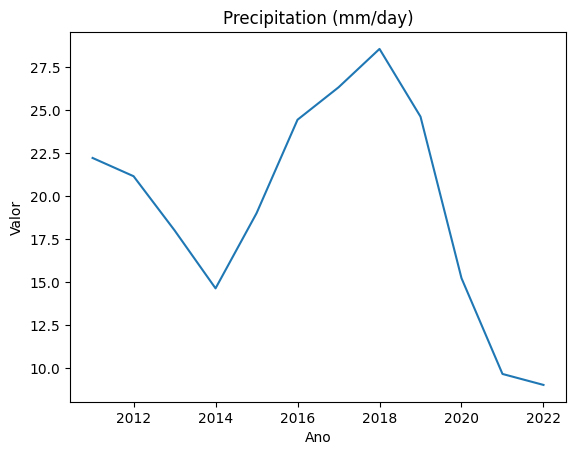

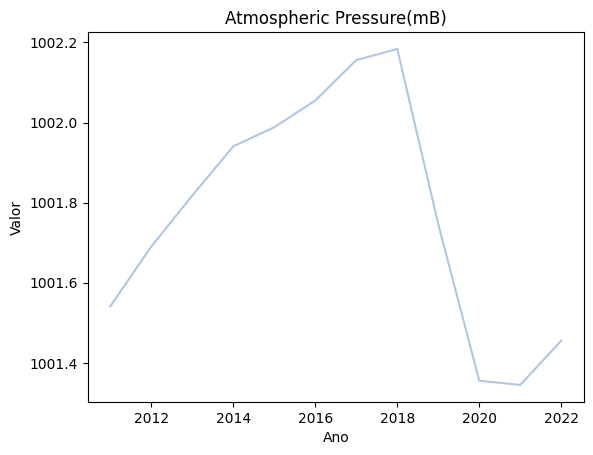

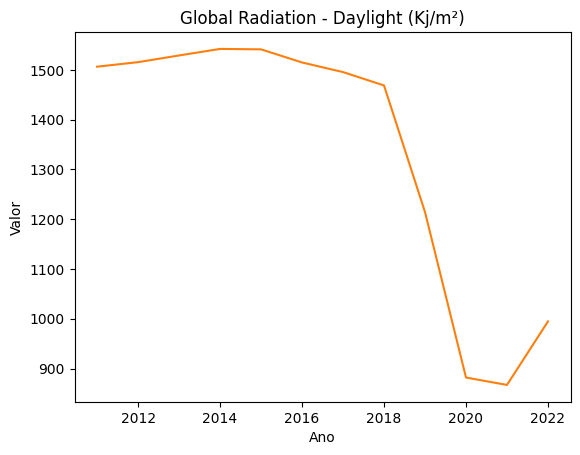

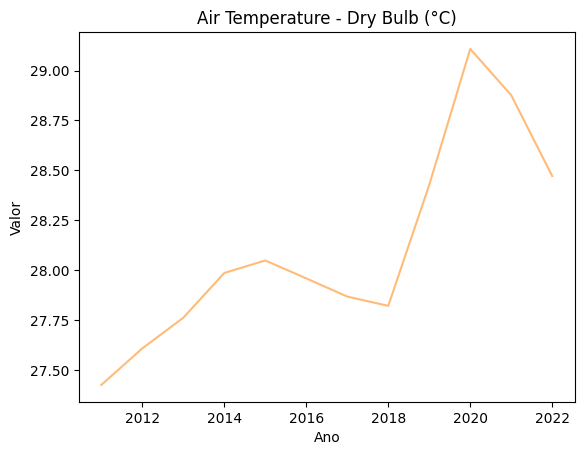

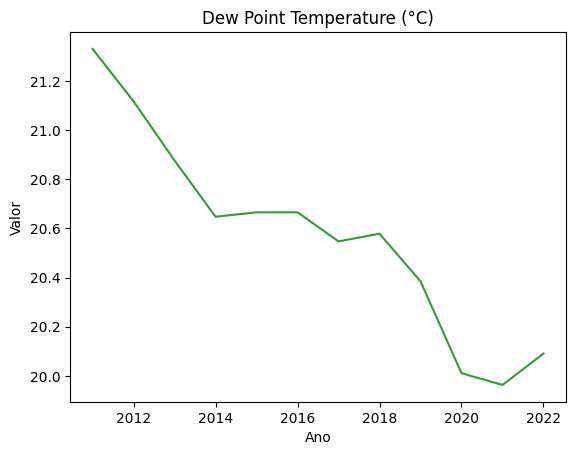

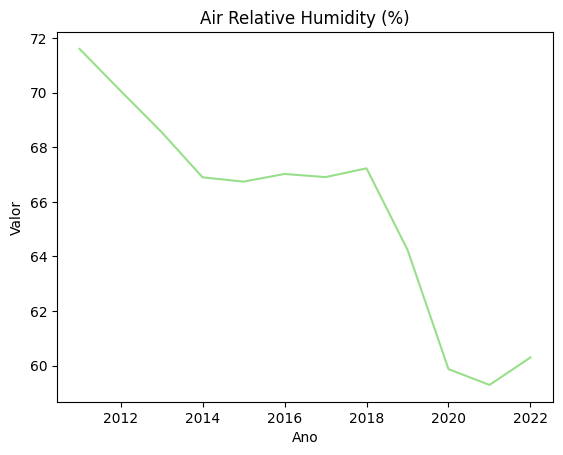

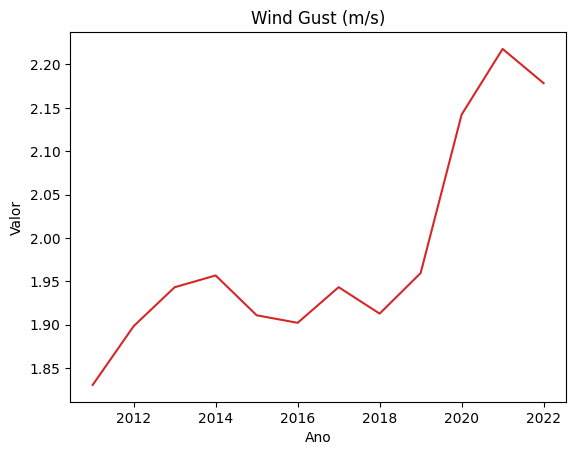

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
Ano,,,,,,,
2011,22.217634,1001.541199,1506.456126,27.425647,21.330889,71.595088,1.830447
2012,21.157249,1001.690342,1515.527356,27.608612,21.117524,70.061650,1.898255
2013,18.013769,1001.817868,1528.998642,27.762053,20.876766,68.552790,1.943125
2014,14.644773,1001.940536,1542.131372,27.986329,20.647922,66.896135,1.956684
2015,19.007683,1001.988306,1541.272845,28.048825,20.665808,66.738045,1.910770
2016,24.437747,1002.055065,1514.905960,27.959130,20.665948,67.018448,1.902067
2017,26.318142,1002.155784,1495.611624,27.867978,20.547545,66.903661,1.943183
2018,28.548818,1002.183834,1468.719756,27.821635,20.578691,67.224766,1.912675
2019,24.615921,1001.746371,1214.342104,28.427536,20.385092,64.243880,1.959458


In [19]:
df_2008 = df_year[df_year.index >= 2008]
plot_columns(df_2008)
df_2008

In [20]:
df_2008.to_csv('2008_01_meteo.csv', index=True)